# Overview

This Jupyter notebook accompanies the manuscript of Brewin et al. titled “A conceptual approach to partitioning a vertical profile of phytoplankton biomass into contributions from two communities”. It is designed to illustrate how the model is fitted to data from a BGC-Argo float in (WMO 6901573) in the Northern Red Sea using Python coding language.

Please note that this example is designed such that each cell (block of Python code) is run after the previous cell. If you clear or restart, you will need to run through each cell from the start. 

## Data

A full description of the date from the BGC-Argo float and how it is processed is provided in Section 2.1 of the manuscript.

## Model

A full description of the model and how it is tuned to the data is provided in Section 2.2 of the manuscript.

## Python packages required to run the example
    
To run the example the following packages need to be installed. Run the following cell to load the packages

In [1]:
import numpy as np
import seawater as sw # Import CSIRO seawater package
import holteandtalley # Import MLD code available here https://github.com/garrettdreyfus/python-holteandtalley
import netCDF4 as nc
import matplotlib as mpl
import julian
import datetime
import lmfit
import numpy.ma as ma
import pandas as pd
from netCDF4 import Dataset
from holteandtalley import HolteAndTalley
from lmfit import Minimizer, Parameters, report_fit
from math import nan
from matplotlib import pyplot as plt
from pysolar.solar import *
import warnings
warnings.filterwarnings("ignore") # Added to remove the warning "UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray." on 2nd to last cell of code

## Reading BGC-Argo float data using Python 

The following lines of code reads the variables of interest from the BGC-Argo float (WMO 6901573) netCDF file (S-profile) required for fitting the model. This file is available from the CORIOLIS (ifremer) data centres (ftp://ftp.ifremer.fr/ifremer/argo/dac/coriolis/) and has been uploaded to this GitHub repository for use in this example.

Run the following lines of code. Note the comments (# words in green) to guide you through the Python code.

In [2]:
#Define float number
FLOAT_NUMBER = '6901573'

#Read the BGC-Argo netCDF file into Python
BGC_DATA = FLOAT_NUMBER+'_Sprof.nc'
fh = Dataset(BGC_DATA, mode='r')

#Read key information on the float
PROJECT_NAME  = fh.variables['PROJECT_NAME'][:]
PI_NAME       = fh.variables['PI_NAME'][:]
PLATFORM_TYPE = fh.variables['PLATFORM_TYPE'][:]
CYCLE_NUMBER  = fh.variables['CYCLE_NUMBER'][:]

#Print information about the float
print('Project Name =', str(PROJECT_NAME[0].tobytes(), 'utf-8'))
print('PI Name =', str(PI_NAME[0].tobytes(), 'utf-8'))
print('Platform Type =', str(PLATFORM_TYPE[0].tobytes(), 'utf-8'))
print('Maximum Cycle Number =', str(np.max(CYCLE_NUMBER)))

#Read time and locations of profiles
JULD      = fh.variables['JULD'][:]      #Julian day of the profile.
LONGITUDE = fh.variables['LONGITUDE'][:] #Longitude degrees East
LATITUDE  = fh.variables['LATITUDE'][:]  #Latitude degress North

#Read netCDF CORE ARGO 
PRESSURE  = fh.variables['PRES'][:] #Pressure (Dbar) we assume equivalent to depth (m)
TEMP      = fh.variables['TEMP'][:] #Temperature (degrees C)
PSAL      = fh.variables['PSAL'][:] #Salinity (PSU)

#Read netCDF BGC ARGO 
CHLA      = fh.variables['CHLA_ADJUSTED'][:]   #Chlorophyll-a (mg m^-3)
BBP       = fh.variables['BBP700_ADJUSTED'][:] #Backscattering at 700nm (m^-1)
DISS_OXY  = fh.variables['DOXY_ADJUSTED'][:]   #Dissolved Oxygen (micro mole kg^-3)
PAR       = fh.variables['DOWNWELLING_PAR'][:] #Photosynthetically Available Radiation

#Close netCDF file
fh.close()

Project Name = RemOcean                                                        
PI Name = Herve CLAUSTRE                                                  
Platform Type = PROVOR_III                      
Maximum Cycle Number = 176


## Compute additional variables from the BGC-Argo data

The next cell of code does the following:
1. Uses Python functions to convert the time variable from Julian day to datetime.
2. Compute Solar Zenith Angle
3. Converting Pressure (Dbar) to Depth (metres) using the "Seawater EOS80 package" (CSIRO, 2014).

Run the following lines of code. Make note of the comments (# words in green).

In [3]:
#Convert time from Julian day to Year-Month-Day T HOUR:MINUTE:SECOND
REFERENCE_DATE = 2433282.50000 #JULIAN DATE for reference 1950-01-01 00:00:00
TIME_BGC       = np.empty(len(JULD), dtype='datetime64[s]')
for i in range(len(JULD)):
    TIME_BGC[i] = julian.from_jd(JULD[i]+REFERENCE_DATE, fmt='jd')

#Compute Solar Zenith Angle
DH_TIME_BGC = pd.DatetimeIndex(TIME_BGC, dtype='datetime64[ns]', name='date_time', freq=None)
SZA_BGC     = np.empty(len(JULD))
for i in range(len(JULD)):    
    dobj = datetime.datetime(int(DH_TIME_BGC.year[i]),int(DH_TIME_BGC.month[i]),int(DH_TIME_BGC.day[i]), \
                             int(DH_TIME_BGC.hour[i]),int(DH_TIME_BGC.minute[i]), tzinfo=datetime.timezone.utc)
    SZA_BGC[i] = float(90)-get_altitude(LATITUDE[i], LONGITUDE[i], dobj)    

#Compute absolute depth and denisty from seawater package
#Define new variables (same size as pressure)
DEPTH     = PRESSURE*0
for i in range(len(JULD)):
    DEPTH[i,:]   = sw.dpth(PRESSURE[i,:], LATITUDE[i]) # use "sw.dpth" function to calculate depth from pressure

## Select a profile from the BGC-Argo to work with 

The maximum cycle number of this BGC-Argo float is 176. So profiles numbers must vary between 1-176. Run the following lines of code.

In [4]:
#Select profile number 
# For a mixed profile try 51
# For a stratified profile try 120
INDEX_PROFILE = 114# #Change number here (between 1-176)

#Check INDEX_PROFILE is greater than maximum cycle number
if INDEX_PROFILE > np.max(CYCLE_NUMBER):
    print("ERROR INDEX_PROFILE number is higher than maximum cycle number")

#Check INDEX_PROFILE is less than minimum cycle number
if INDEX_PROFILE < np.min(CYCLE_NUMBER):
    print("ERROR INDEX_PROFILE number is lower than minimum cycle number")

#Python starts index on 0 not 1, so 1 need to be subtracted from index
INDEX_PROFILE = INDEX_PROFILE - 1

## Compute Kd, surface chlorophyll-a, surface bbp and mixed-layer depth.
Having retrieved and/or computed all the variables required, next we will 
1. Derive the diffuse attenuation coefficient for photosynthetically available radiation ($K_d$), in the upper 100 m.
2. Derive surface chlorophyll-a and surface bbp (median in the 1st optical depth)
3. Estuimate the mixed-layer depth using the method of Holt and Tally (2009 https://doi.org/10.1175/2009JTECHO543.1)

Run the following lines of code.

In [5]:
################Compute Diffuse attenuation coefficient from PAR data##############
##Define function for diffuse attenuation coefficient
def fcn2min_Kds(params1, X1, Y1):
        G1 = params1['G1']
        KD = params1['KD']
        model = G1+(-KD*X1)
        return(model-Y1)
##Extract PAR and Depth data from profile
X      = DEPTH[INDEX_PROFILE,:]
Y      = PAR[INDEX_PROFILE,:]
##Select only data with both PAR and Depth
valid1 = np.logical_not(ma.getmask(Y))
X      = X[valid1]
Y      = Y[valid1]
valid2 = np.logical_not(ma.getmask(X))
X      = X[valid2]
Y      = Y[valid2]
##Extract top 100m
idx    = np.where(X <= 100) #top 100 m for comoputing Kd
X      = X[idx]
Y      = Y[idx]
##Only take data where PAR >= 0 
idx    = np.where(Y >= 0)
X      = X[idx]
Y      = Y[idx]
##Log PAR (linear fit in log-space)
Y      = np.log(Y)
X      = X
##Initial guess of parameters
params1 = Parameters()
params1.add('G1', value=4.0)  #Initial guess
params1.add('KD', value=0.05) #Initial guess
##Only fit model where Solar Zenith Angle < 90 degrees
if SZA_BGC[INDEX_PROFILE] < 90.:
    ##Only fit model where greater than 10 measurements
    if len(Y) > 10: #has to be at least 10 data point to fit otherwise call nan
        out    = Minimizer(fcn2min_Kds, params1, fcn_args=(X, Y))
        result = out.minimize()
        G1_FIT = result.params['G1'].value
        KD_FIT = result.params['KD'].value
    else:
        G1_FIT = nan
        KD_FIT = nan
else:
    G1_FIT = nan
    KD_FIT = nan

##For cases where KD is nan, estimate KD from mean surface Chl-a (top 10 m) using equation from paper
##Compute surface Chl and KD
CHL_SURF_INITAL = nan
if np.isnan(KD_FIT):
    X        = DEPTH[INDEX_PROFILE,:]
    Y        = CHLA[INDEX_PROFILE,:]
    valid1   = np.logical_not(ma.getmask(Y))
    X        = X[valid1]
    Y        = Y[valid1]
    valid2   = np.logical_not(ma.getmask(X))
    X        = X[valid2]
    Y        = Y[valid2]
    idx      = np.where(X <= 10.0)
    if len(idx[0]) >0:
        CHL_SURF_INITAL= np.mean(Y[idx])
        KD_FIT = 0.036*CHL_SURF_INITAL+0.049

################Compute surface Chl-a and bbp (1st optical depth) ##############    
##Chlorophyll-a
##Compute 1st optical depth
FIRST_OD = 1.0/KD_FIT
##Extract Chl and depth from profile  
Y        = CHLA[INDEX_PROFILE,:]
X        = DEPTH[INDEX_PROFILE,:]
##Select only data with both Chl and depth
valid1   = np.logical_not(ma.getmask(Y))
X        = X[valid1]
Y        = Y[valid1]
valid2   = np.logical_not(ma.getmask(X))
X        = X[valid2]
Y        = Y[valid2]
##Find depths <= to 1st optical depth
idx       = np.where(X <= FIRST_OD)
##Compute median Chl in 1st optical depth
if len(idx[0]) > 0:
    CHL_TEMP = Y[idx]
    asd      = np.where(CHL_TEMP >= 0.01)
    CHL_SURF = np.median(CHL_TEMP[asd])
else:
    CHL_SURF = nan
##bbp    
##Extract bbp and depth from profile 
Y        = BBP[INDEX_PROFILE,:]
X        = DEPTH[INDEX_PROFILE,:]
##Select only data with both bbp and depth
valid1   = np.logical_not(ma.getmask(Y))
X        = X[valid1]
Y        = Y[valid1]
valid2   = np.logical_not(ma.getmask(X))
X        = X[valid2]
Y        = Y[valid2]
##Find depths <= to 1st optical depth
idx      = np.where(X <= FIRST_OD)
##Compute median bbp in 1st optical depth
if len(idx[0]) >0:
    BBP_TEMP = Y[idx]
    asd      = np.where(BBP_TEMP > 0.0)
    BBP_SURF = np.median(BBP_TEMP[asd])
else:
    BBP_SURF = nan    

################Compute mixed-layer depth Holt and Tally (2009) ##############      
##Extract data from input to code
A = PRESSURE[INDEX_PROFILE,:]
B = TEMP[INDEX_PROFILE,:]
##Only use data where all variables available 
valid1 = np.logical_not(ma.getmask(A))
A      = A[valid1]
B      = B[valid1]
valid1 = np.logical_not(ma.getmask(B))
A      = A[valid1]
B      = B[valid1]
#Only compute if more than 100 measurements
if len(A) > 100:
    h = HolteAndTalley(A,B)
    ##The temperature algorithms mixed layer depth
    MLD_TEMP = h.tempMLD
else:
    MLD_TEMP = nan
    
##Print output
print('Kd =', str(KD_FIT))
print('Surface Chl-a =', str(CHL_SURF))
print('Surface bbp =', str(BBP_SURF))
print('MLD =', str(MLD_TEMP))

Kd = 0.052441726078176175
Surface Chl-a = 0.014355000108480453
Surface bbp = 0.000590756069868803
MLD = 25.5


## Fit the two community model to a profile and plot results

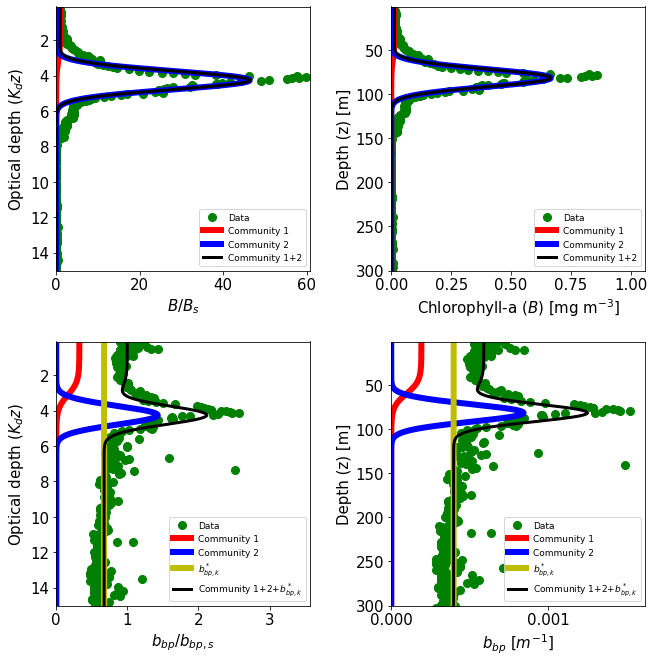

In [6]:
##Define the functions needed for the fitting
##Equation 8 of the paper
def fcn2min_1pop(params1, X, Y):
    P1 = params1['P1']
    P2 = params1['P2']
    model = 1 - 1./(1+np.exp(-(P1/P2)*(Y-P2))) 
    return(model-X)
##Equation 7 of the paper
def fcn2min_2pop(params2, X, Y):
    P1 = params2['P1']
    P2 = params2['P2']
    P3 = params2['P3'] 
    P4 = params2['P4'] 
    P5 = params2['P5'] 
    MLD_pop = 1 - 1./(1+np.exp(-(P1/P2)*(Y-P2)))
    DCM_pop = P3*np.exp(-((Y - ((P4+(P5*3.000))))/(P5))**2.) 
    model = MLD_pop + DCM_pop
    return(model-X)
##Equation 13 of the paper
def fcn3min_bbp_norm_1pop(params2, X1, A1):
    #Input parameters
    P2 = params2['P2']
    model   = (1.-P2)*A1 + P2
    return(model-X1)
##Equation 14 of the paper
def fcn3min_bbp_norm_2pop(params1, X1, A1, A2):
    #Input parameters
    P1 = params1['P1']
    P2 = params1['P2']
    model   = (1.-P2)*A1 + P1*A2 + P2
    return(model-X1)

##Only run code if data is available (Kd = nan as index for no available data)
if np.isnan(KD_FIT):
    print("No data available for the fit")
else:
    #####################Chlorophyll fit##################
    ###Dimensionalise the profiles
    CHL_DIM  = CHLA[INDEX_PROFILE,:]/CHL_SURF  #Dimensionless chl
    OPT_DIM  = DEPTH[INDEX_PROFILE,:]*KD_FIT   #Dimensionless tau
    MLD_OD   = MLD_TEMP*KD_FIT                 #Optical depth of mixed layer
    ###Only select data <9.2 Optical depths if MLD_opt < 9.2
    if MLD_OD < 9.2:
        valid1  = np.where(OPT_DIM < 9.2)
        CHL_DIM = CHL_DIM[valid1]
        OPT_DIM = OPT_DIM[valid1]
    ###Process data to be used for Chl fit
    X1        = CHL_DIM
    Y1        = OPT_DIM
    valid1    = np.logical_not(ma.getmask(X1))
    X1        = X1[valid1]
    Y1        = Y1[valid1]
    valid1    = np.logical_not(ma.getmask(Y1))
    X1        = X1[valid1]
    Y1        = Y1[valid1]
    ## Profile has to have as a minimum of more measurements +1 than parameters (6 for Eq. 7)        
    if len(X1) > 6:
        ###Fit 1st population
        params1  = Parameters()
        params1.add('P1', value=9., min = 4.6, max = 100)
        params1.add('P2', value=MLD_OD)
        out      = Minimizer(fcn2min_1pop, params1, fcn_args=(X1, Y1))
        result   = out.minimize()
        P1_FIT   = result.params['P1'].value
        P2_FIT   = result.params['P2'].value
        AIC_FIT1 = result.aic
        CHI_FIT1 = result.chisqr
        MLD_pop  = 1 - 1./(1+np.exp(-(P1_FIT/P2_FIT)*(Y1-P2_FIT)))
        r        = np.corrcoef(X1, MLD_pop)
        #report_fit(result) ##uncomment if you want to see results of fit
        ###Fit 2nd population
        params2 = Parameters()
        if r[1,0]**2 >= 0.9: 
            P3_FIT = nan
            P4_FIT = nan
            P5_FIT = nan
        else:
        ###Estimate tau1 and S1 from Optical depth of mixed layer  
            Tau1_temp = (MLD_OD*0.62)+2.296
            P1_temp   = 10**(0.08 * Tau1_temp + 0.66)
            params2.add('P1', value=P1_temp, vary=False) #Fixed
            params2.add('P2', value=Tau1_temp, vary=False) #Fixed
            params2.add('P3', value=5.0, min = 0.0, max = 100.0)
            params2.add('P4', value=4.6, min = 0.0)
            params2.add('P5', value=1.0, min = 0.0)
            res      = Minimizer(fcn2min_2pop,  params2, fcn_args=(X1, Y1))
            result   = res.minimize()
            AIC_FIT2 = result.aic
            CHI_FIT2 = result.chisqr
            #report_fit(result) ##uncomment if you want to see results of fit
            if AIC_FIT2 < AIC_FIT1: 
                P1_FIT = result.params['P1'].value
                P2_FIT = result.params['P2'].value
                P3_FIT = result.params['P3'].value
                P4_FIT = result.params['P4'].value
                P5_FIT = result.params['P5'].value
            else:
                P3_FIT = nan
                P4_FIT = nan
                P5_FIT = nan
    else:
        P1_FIT = nan
        P2_FIT = nan
        P3_FIT = nan
        P4_FIT = nan
        P5_FIT = nan
    ###Extract parameters from the xhlorophyll fit
    P1_TEMP   = P1_FIT                                                                                                         
    TAU1_TEMP = P2_FIT
    BM2_TEMP  = P3_FIT
    TAU2_TEMP = P4_FIT + P5_FIT * 3.0
    SIG2_TEMP = P5_FIT
        
    ######################Backscattering fit##################  
    ##Dimensionalise the profiles
    BBP_DIM = BBP[INDEX_PROFILE,:]/BBP_SURF   #Dimensionless bbp
    OPT_DIM = DEPTH[INDEX_PROFILE,:]*KD_FIT   #Dimensionless tau
    DEP_TEM = DEPTH[INDEX_PROFILE,:]          #Depth for removing >500m values
    #Top 500 m
    valid1  = np.where(DEP_TEM < 500.)
    BBP_DIM = BBP_DIM[valid1]
    OPT_DIM = OPT_DIM[valid1]
    ###Process data to be used for bbp fit
    X1        = BBP_DIM
    Y1        = OPT_DIM
    A1        = 1 - 1./(1+np.exp(-(P1_TEMP/TAU1_TEMP)*(Y1-TAU1_TEMP)))
    A2        = BM2_TEMP*np.exp(-((Y1 - TAU2_TEMP)/SIG2_TEMP)**2.)
    valid1    = np.logical_not(ma.getmask(X1))
    X1        = X1[valid1]
    Y1        = Y1[valid1]
    A1        = A1[valid1]
    A2        = A2[valid1]
    valid1    = np.logical_not(ma.getmask(Y1))
    X1        = X1[valid1]
    Y1        = Y1[valid1]
    A1        = A1[valid1]
    A2        = A2[valid1]
    if len(X1) > 6:
        if np.isnan(BM2_TEMP): #Index of whether Eq 7 or 8 fitted to Chl-a profile
            params1.add('P2', value=0.3, min = 0.01, max = 0.95)
            out          = Minimizer(fcn3min_bbp_norm_1pop, params1, fcn_args=(X1, A1))
            result       = out.minimize()
            bbpST1_TEMP  = 1 - result.params['P2'].value
            bbpST2_TEMP  = nan
            bbpSk_TEMP   = result.params['P2'].value
        else:
            params1.add('P1', value=0.2, min = 0.01)
            params1.add('P2', value=0.3, min = 0.01, max = 0.95)
            out     = Minimizer(fcn3min_bbp_norm_2pop, params1, fcn_args=(X1, A1, A2))
            result  = out.minimize()
            bbpST1_TEMP  = 1 - result.params['P2'].value
            bbpST2_TEMP  = result.params['P1'].value
            bbpSk_TEMP   = result.params['P2'].value
    else:
        bbpST1_TEMP  = nan
        bbpST2_TEMP  = nan
        bbpSk_TEMP   = nan
    
    ######################PLOT DATA##################  
    ###Take dimensionless data for plots 
    BBP_DIM = BBP[INDEX_PROFILE,:]/BBP_SURF   #Dimensionless bbp
    CHL_DIM = CHLA[INDEX_PROFILE,:]/CHL_SURF  #Dimensionless chl
    OPT_DIM = DEPTH[INDEX_PROFILE,:]*KD_FIT   #Dimensionless tau
    DEP_TEM = DEPTH[INDEX_PROFILE,:]          #Keep depth
    ###CHL MODEL
    MLD_pop_FIT = 1 - 1./(1+np.exp(-(P1_TEMP/TAU1_TEMP)*(OPT_DIM-TAU1_TEMP)))
    DCM_pop_FIT = BM2_TEMP*np.exp(-((OPT_DIM - TAU2_TEMP)/SIG2_TEMP)**2.) 
    
    ##BBP MODEL
    MLD_pop_FIT_BBP = MLD_pop_FIT*bbpST1_TEMP
    DCM_pop_FIT_BBP = DCM_pop_FIT*bbpST2_TEMP
    BBBK_FIT        = (MLD_pop_FIT*0.)+bbpSk_TEMP ##Fill array same size with background
    ##For Community 1 only
    if np.isnan(P3_FIT): 
        model_FIT_CHL_DIM   = MLD_pop_FIT 
        model_FIT_CHL_DIM_1 = MLD_pop_FIT
        model_FIT_CHL_DIM_2 = MLD_pop_FIT*0
        model_FIT_BBP_DIM   = MLD_pop_FIT_BBP  + BBBK_FIT
        model_FIT_BBP_DIM_1 = MLD_pop_FIT_BBP 
        model_FIT_BBP_DIM_2 = MLD_pop_FIT_BBP*0
        model_FIT_BBP_DIM_K = BBBK_FIT
        model_FIT_CHL       = model_FIT_CHL_DIM * CHL_SURF
        model_FIT_CHL_1     = model_FIT_CHL_DIM_1* CHL_SURF
        model_FIT_CHL_2     = model_FIT_CHL_DIM_2* CHL_SURF
        model_FIT_BBP       = model_FIT_BBP_DIM  * BBP_SURF
        model_FIT_BBP_1     = model_FIT_BBP_DIM_1* BBP_SURF
        model_FIT_BBP_2     = model_FIT_BBP_DIM_2* BBP_SURF
        model_FIT_BBP_K     = model_FIT_BBP_DIM_K* BBP_SURF
    ##For Community 1 and 2    
    else:
        model_FIT_CHL_DIM   = MLD_pop_FIT + DCM_pop_FIT
        model_FIT_CHL_DIM_1 = MLD_pop_FIT
        model_FIT_CHL_DIM_2 = DCM_pop_FIT
        model_FIT_BBP_DIM   = MLD_pop_FIT_BBP + DCM_pop_FIT_BBP + BBBK_FIT
        model_FIT_BBP_DIM_1 = MLD_pop_FIT_BBP 
        model_FIT_BBP_DIM_2 = DCM_pop_FIT_BBP
        model_FIT_BBP_DIM_K = BBBK_FIT
        model_FIT_CHL       = model_FIT_CHL_DIM * CHL_SURF
        model_FIT_CHL_1     = model_FIT_CHL_DIM_1* CHL_SURF
        model_FIT_CHL_2     = model_FIT_CHL_DIM_2* CHL_SURF
        model_FIT_BBP       = model_FIT_BBP_DIM  * BBP_SURF
        model_FIT_BBP_1     = model_FIT_BBP_DIM_1* BBP_SURF
        model_FIT_BBP_2     = model_FIT_BBP_DIM_2* BBP_SURF
        model_FIT_BBP_K     = model_FIT_BBP_DIM_K* BBP_SURF 
    
    ##Create plot 
    XSIZE = 10
    YSIZE = 10
    fig, ([ax1, ax2],[ax3, ax4]) = plt.subplots(2,2, figsize=(XSIZE,YSIZE))
    fig.tight_layout(pad=5.0)
    ##Plot dimensionless Chl-a profiles
    ax1.plot(CHL_DIM,OPT_DIM,color = 'g', marker = 'o', linestyle = 'None', ms = 8, label = 'Data')  
    ax1.plot(model_FIT_CHL_DIM_1,OPT_DIM,color = 'r',linewidth=6.0, label ='Community 1')
    ax1.plot(model_FIT_CHL_DIM_2,OPT_DIM,color = 'b',linewidth=6.0, label ='Community 2')
    ax1.plot(model_FIT_CHL_DIM,OPT_DIM,color = 'k',linewidth=3.0, label ='Community 1+2')
    ax1.xaxis.set_tick_params(labelsize=15)
    ax1.yaxis.set_tick_params(labelsize=15)
    ax1.set_ylim([15,0.1])
    ax1.set_xlim([0,np.max(CHL_DIM)+1])
    ax1.set_ylabel('Optical depth ($K_d$$z$)', fontsize = 15)
    ax1.set_xlabel('$B/B_s$', fontsize = 15)
    ax1.legend(loc="lower right", fontsize=9)
    ##Plot Chl-a profiles
    ax2.plot(CHLA[INDEX_PROFILE,:],DEP_TEM,color = 'g', marker = 'o', ms = 8, linestyle = 'None', label = 'Data')  
    ax2.plot(model_FIT_CHL_1,DEP_TEM,color = 'r',linewidth=6.0, label = 'Community 1')
    ax2.plot(model_FIT_CHL_2,DEP_TEM,color = 'b',linewidth=6.0, label ='Community 2')
    ax2.plot(model_FIT_CHL,DEP_TEM,color = 'k',linewidth=3.0, label= 'Community 1+2')
    ax2.xaxis.set_tick_params(labelsize=15)
    ax2.yaxis.set_tick_params(labelsize=15)
    ax2.set_ylim([300,0.1])
    ax2.set_xlim([0,np.max(CHLA[INDEX_PROFILE,:])+0.2])
    ax2.set_ylabel('Depth (z) [m]', fontsize = 15)
    ax2.set_xlabel('Chlorophyll-a ($B$) [mg m$^{-3}$]', fontsize = 15)
    ax2.legend(loc="lower right", fontsize=9)
    ##Plot dimensionless bbp profiles
    ax3.plot(BBP_DIM,OPT_DIM,color = 'g', marker = 'o', linestyle = 'None', ms = 8, label = 'Data')  
    ax3.plot(model_FIT_BBP_DIM_1,OPT_DIM,color = 'r',linewidth=6.0, label ='Community 1')
    ax3.plot(model_FIT_BBP_DIM_2,OPT_DIM,color = 'b',linewidth=6.0, label ='Community 2')
    ax3.plot(model_FIT_BBP_DIM_K,OPT_DIM,color = 'y',linewidth=6.0, label ='$b^*_{bp,k}$')
    ax3.plot(model_FIT_BBP_DIM,OPT_DIM,color = 'k',linewidth=3.0, label= 'Community 1+2+$b^*_{bp,k}$')
    ax3.xaxis.set_tick_params(labelsize=15)
    ax3.yaxis.set_tick_params(labelsize=15)
    ax3.set_ylim([15,0.1])
    ax3.set_xlim([0,np.max(BBP_DIM)+1])
    ax3.set_ylabel('Optical depth ($K_d$$z$)', fontsize = 15)
    ax3.set_xlabel('$b_{bp}/b_{bp,s}$', fontsize = 15)
    ax3.legend(loc="lower right", fontsize=9)
    ##Plot bbp profiles
    ax4.plot(BBP[INDEX_PROFILE,:],DEP_TEM,color = 'g', marker = 'o', linestyle = 'None', ms = 8, label = 'Data')  
    ax4.plot(model_FIT_BBP_1,DEP_TEM,color = 'r',linewidth=6.0, label ='Community 1')
    ax4.plot(model_FIT_BBP_2,DEP_TEM,color = 'b',linewidth=6.0, label ='Community 2')
    ax4.plot(model_FIT_BBP_K,DEP_TEM,color = 'y',linewidth=6.0, label ='$b^*_{bp,k}$')
    ax4.plot(model_FIT_BBP,DEP_TEM,color = 'k',linewidth=3.0, label= 'Community 1+2+$b^*_{bp,k}$')
    ax4.xaxis.set_tick_params(labelsize=15)
    ax4.yaxis.set_tick_params(labelsize=15)
    ax4.locator_params(axis="x", nbins=3)
    ax4.set_ylim([300,0.1])
    ax4.set_xlim([0,np.max(BBP[INDEX_PROFILE,:])+0.0001])
    ax4.set_ylabel('Depth (z) [m]', fontsize = 15)
    ax4.set_xlabel('$b_{bp}$ [$m^{-1}$]', fontsize = 15)
    ax4.legend(loc="lower right", fontsize=9)
    ##Close plot
    plt.show()